In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import keras.backend as K
from keras.metrics import binary_crossentropy
from math import sqrt
from skimage.transform import resize
import logging
import sys
import tensorflow as tf
import sys; #sys.path.append('../')
from src.models.unet_dilation_deep_original import UNet
from src.utils.runtime import gpu_selection
from src.utils.data import random_transforms
from src.utils.model import dice_coef, jaccard_coef
import cv2
import numpy as np
import cv2
import glob
import random
from matplotlib.image import imsave
import mahotas as mh
from scipy import ndimage
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils.model import dice_coef, jaccard_coef,tru_pos,fls_pos,tru_neg,fls_neg


sns.set_style("whitegrid", {'axes.grid' : False})


Using TensorFlow backend.
/apps/well/python/3.5.2-gcc5.4.0/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# ndog_mont_img = np.load('gtex_montage/gtex_montage_img2_trn.npy')

In [3]:
# plt.figure(figsize=(15,20))
# plt.imshow(ndog_mont_img,cmap='gray')

In [4]:
# ndog_mont_msk = np.load('gtex_montage/gtex_montage_msk2_trn.npy')
# plt.figure(figsize=(15,20))
# plt.imshow(ndog_mont_msk,cmap='gray')


In [5]:
import keras

In [7]:
#model = UNet()
model = UNet('unet')
model.config['data_path'] = '.'
model.load_data()

In [8]:
gpu_selection(visible_devices="0")
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
session = tf.Session(config=config)

In [9]:
model.compile() # THIS IS USING BEST VALIDATION LOSS WEIGHTS :]
model.net.load_weights('/well/lindgren/craig/isbi-2012/checkpoints/unet_1024_dilation/weights_loss_val.weights')
# model.net.summary()

In [10]:
import pandas as pd

test_tiles=pd.read_csv('adipoTiles.labeled.csv')
test_tiles.head()


,image,empty,not_adipocyte,adipocyte,sampleID
0,0-10240_GTEX-13QJC_Adipose-Subcutaneous.jpg,0.002056,0.000137,0.997807,GTEX-13QJC
1,0-10240_GTEX-RWSA_Adipose-Subcutaneous.jpg,0.072163,0.005093,0.922744,GTEX-RWSA
2,0-11264_GTEX-13QJC_Adipose-Subcutaneous.jpg,0.001999,0.001127,0.996874,GTEX-13QJC
3,0-11264_GTEX-RWSA_Adipose-Subcutaneous.jpg,0.000227,0.000176,0.999597,GTEX-RWSA
4,0-12288_GTEX-13QJC_Adipose-Subcutaneous.jpg,0.000577,0.000240,0.999183,GTEX-13QJC


In [12]:
adipocyte_tiles = test_tiles[test_tiles['adipocyte'] > 0.90].reset_index()
len(adipocyte_tiles)

499988

In [13]:
#adipocyte_tiles = adipocyte_tiles[adipocyte_tiles['sampleID'] !='ImageCollection'].reset_index()


Out of sample prediction on an image neither trained nor validated on.

In [14]:
def norm_img(img,mean,std):
    out=[]
    test_sample = np.array(img,np.float32)
    test_sample= (test_sample - mean) / (std + 1e-10)
    out.append(test_sample)
    out=np.array(out)
    return(out)

In [15]:
def predict_areas(prd_batch,label):
    #prd_batch = prd_batch[0] > 0.20
    #img = np.array(prd_batch * 255,dtype='uint8')
    #T = mh.thresholding.otsu(img)
    if label =='NDOG':
        blobs = np.where(prd_batch[0]>0.1,0, 1)
    else:
        blobs = np.where(prd_batch[0] > 0.80, 0, 1)
    blobs = np.array(cv2.erode((blobs *1.0).astype(np.float32),np.ones((3,3))),dtype='int8')
    blobs = ndimage.morphology.binary_fill_holes(blobs,structure=np.ones((5,5))).astype(int)
    labels, no_objects = ndimage.label(blobs)
    props = regionprops(blobs)
    labelled=ndimage.label(blobs)
    resh_labelled=labelled[0].reshape((img.shape[0],img.shape[1])) #labelled is a tuple: only the first element matters
    props=regionprops(resh_labelled) 
    size={i:props[i].area for i in range (0, no_objects)}
    no_of_cells=(sum(i > 200 and i < 100000 for i in size.values()))
    areas=[i for i in size.values() if i >= 200 and i <= 100000]
    areas=np.array(areas)
    return(blobs,np.median(areas),np.mean(areas),np.std(areas),no_of_cells)
    



In [19]:
from skimage import img_as_uint
import time
start = time.time()

out_batch=[]
j=1
for i in adipocyte_tiles['image']:
    img=cv2.imread('../tile_classifier/test/test/%s'%(i),0)
    normalised_img = np.expand_dims((img - np.mean(img)) / np.std(img),0)
    prd_batch = model.net.predict(normalised_img,batch_size=1)
    if adipocyte_tiles['sampleID'][j] =='ImageCollection':
        label = 'NDOG'
    else:
        label ='GTEX'
    blobs,median_area,mean_area,std_area,no_cells = predict_areas(prd_batch,label)
    if j ==0:
        print('image','median_area','mean_area','std_dev_area','no_cells')
    if j <= 100:
        print(i,median_area,mean_area,std_area,no_cells)
    if adipocyte_tiles['sampleID'][j] =='ImageCollection':
        imsave('predicted_masks/NDOG/Pred_Mask_{}.png'.format(i.split('.')[0]),blobs,cmap='gray')
    else:
        imsave('predicted_masks/GTEX/Pred_Mask_{}.png'.format(i.split('.')[0]),blobs,cmap='gray')
    j+=1
end = time.time()
print('Total time taken {}'.format(end-start))

0-10240_GTEX-13QJC_Adipose-Subcutaneous.jpg 11972.0 15004.245283018869 12520.312285733495 53
0-10240_GTEX-RWSA_Adipose-Subcutaneous.jpg 9028.0 13460.15 14405.964480988421 40
0-11264_GTEX-13QJC_Adipose-Subcutaneous.jpg 12096.5 14429.75925925926 11477.571852409772 54
0-11264_GTEX-RWSA_Adipose-Subcutaneous.jpg 17076.0 18507.577777777777 10307.134962385984 45
0-12288_GTEX-13QJC_Adipose-Subcutaneous.jpg 12158.5 15031.642857142857 11067.234740486008 56
0-14336_GTEX-13QJC_Adipose-Subcutaneous.jpg 10332.0 15302.358974358975 14482.75922762981 39
0-15360_GTEX-13QJC_Adipose-Subcutaneous.jpg 15835.5 18226.270833333332 12330.09692402359 48
0-15360_GTEX-15ER7_Adipose-Subcutaneous.jpg 5748.5 10665.56 11646.143437481784 50
0-16384_GTEX-13QJC_Adipose-Subcutaneous.jpg 16214.0 17512.48979591837 12063.49807480883 49
0-16384_GTEX-15G1A_Adipose-Subcutaneous.jpg 4666.0 7014.831460674157 10413.190990855972 89


KeyboardInterrupt: 

In [242]:
img=cv2.imread('../tile_classifier/test/test/%s'%(i),0)
img_mean, img_stdev = np.mean(img), np.std(img)
normalised_img = norm_img(img,img_mean,img_stdev)

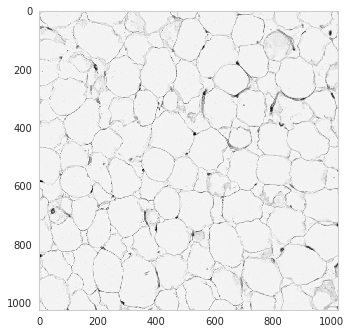

In [243]:
plt.imshow(img,cmap='gray')

In [244]:
prd_batch = model.net.predict(normalised_img,batch_size=1)

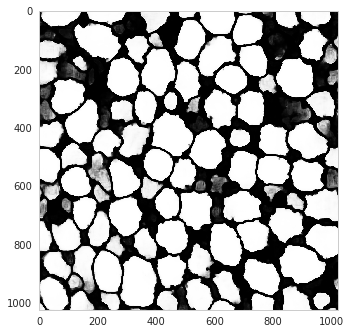

In [245]:
plt.imshow(prd_batch[0])

In [254]:
blobs = np.where(prd_batch[0] > 0.80, 0, 1)
blobs = np.array(cv2.erode((blobs *1.0).astype(np.float32),np.ones((3,3))),dtype='int8')


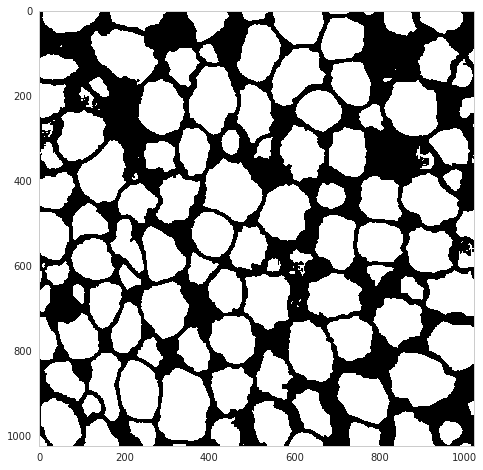

In [255]:
blobs = ndimage.morphology.binary_fill_holes(blobs,structure=np.ones((3,3))).astype(int)
plt.figure(figsize=(8,8))
plt.imshow(blobs,cmap='gray')

In [59]:
img = cv2.imread('/well/lindgren/craig/Julius_histology/m006/m006_SC_ (4).tif',0)
img = cv2.resize(img, (1024,1024))
img_mean, img_stdev = np.mean(img), np.std(img)
normalised_img = norm_img(img,img_mean,img_stdev)
prd_batch = model.net.predict(normalised_img,batch_size=1)
blobs,median_area,mean_area,std_area,no_cells = predict_areas(prd_batch)

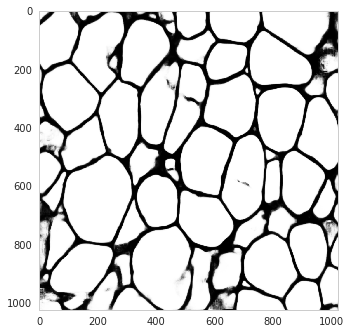

In [60]:
plt.imshow(prd_batch[0])

In [61]:
blobs = np.where(prd_batch[0]>0.7,0, 1)
blobs = ndimage.morphology.binary_fill_holes(blobs,structure=np.ones((3,3))).astype(int)

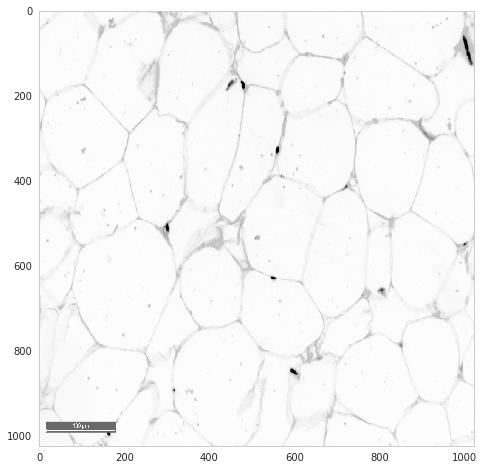

In [62]:
plt.figure(figsize=(8,8))
plt.imshow(img)

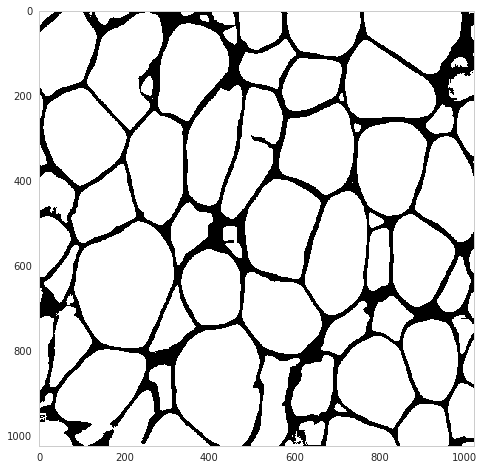

In [63]:
plt.figure(figsize=(8,8))
plt.imshow(blobs, cmap='gray')

In [29]:
plt.imsave('predicted_mask.png',prd_batch[0],cmap='gray')